# Homework 11

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.rcParams['figure.figsize'] = (10, 8)

# Выборка - реализация бернулевской величины. 

In [66]:
data = pd.read_csv('../../homework_data/sem_11/ugnivenko.va.csv', header = None)
data.head(5)

,0
0,1
1,0
2,0
3,0
4,1


# Оценка вероятности методом максимального правдоподобия. (Ответ округлите до 3-х знаков после запятой).

Пусть наша случайная величина $\xi$ 

$$\xi \sim Be(p)$$

$$P(\xi = j) = p^j\cdot(1-p)^{1-j}$$

Тогда функция правдоподобия 

$$F(\{\xi_i\}_{i=1}^N) = p^s \cdot(1-p)^{(N - s)} $$

Где 

$$s = \sum_{i=1}^N \xi_i $$

Тогда логарифм функции правдоподобия 

$$L(\{\xi_i\}_{i=1}^N) = s\cdot\ln(p) + \ln(1-p)\cdot({N-s}) $$

Продифиренцируем по p и приравняем к нулю

$$\dfrac{s}{p}-\dfrac{N-s}{1-p} = 0$$

Откуда 

$$ p = \dfrac{s}{N}$$

In [67]:
def p_opt(sample):
    return sum(sample)/len(sample)

In [68]:
p = np.round(p_opt(data.values)[0], decimals =3)
print(f'p_opt = {p}')

p_opt = 0.59


# С помощью последовательного анализа проверить нулевую гипотезу p0=0.5 против p1, полученной методом максимального правдоподобия. Использовать библиотеку sprt с alpha=beta=0.05. Гипотеза принимается? 

Decision:	Reject

      values     lower     upper
n                               
4991    2946  2713.237  2729.416
4992    2947  2713.782  2729.962
4993    2948  2714.327  2730.507
4994    2949  2714.872  2731.052
4995    2950  2715.418  2731.597
4996    2951  2715.963  2732.143
4997    2951  2716.508  2732.688
4998    2951  2717.053  2733.233
4999    2951  2717.599  2733.778
5000    2952  2718.144  2734.324


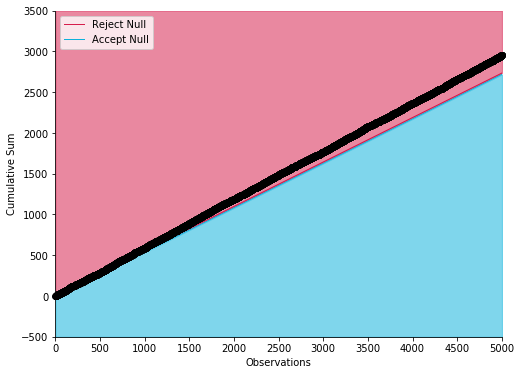

In [69]:
import sprt
alpha = beta = 0.05

test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=0.59, values=data.values)
test.plot()

Отклоняется

# Какое минимальное количество итераций требуется для вынесения решения по данной гипотезе? 

In [70]:
pl = 0.5
pu = p
alpha = beta = 0.05
A = (1 - beta) / alpha
B = beta / (1 - alpha)

def a_m(m):
    return (np.log(B) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 - pl)))

def r_m(m):
    return (np.log(A) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 -pl)))

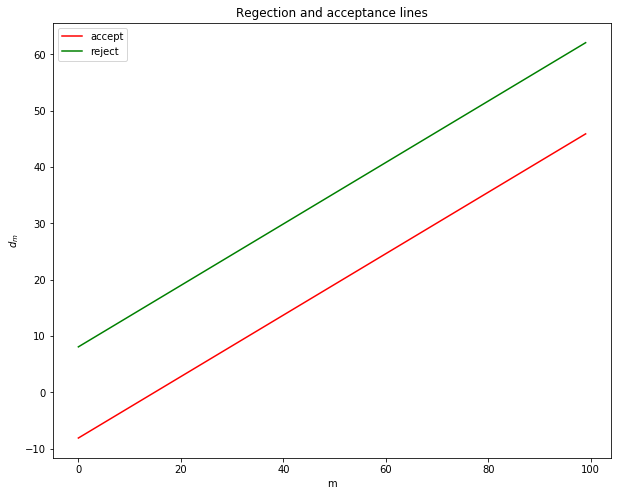

In [71]:
plt.plot(range(100), [a_m(i) for i in range(100)], label='accept', color='red')
plt.plot(range(100), [r_m(i) for i in range(100)], label='reject', color='green')
plt.xlabel('m')
plt.ylabel('$d_m$')
plt.legend(loc='best')
_ = plt.title('Regection and acceptance lines')

In [72]:
def generate_and_test(data, maxm=500, seed=42):
    
    data = data.values.tolist()
    m = 0
    sample = []
    iter_num = -1 # номер итерации, где мы выходим за пределы области безразличия
    
    while m < maxm and (iter_num < 0):
        x = data[m]
        m += 1
        sample += x
        if iter_num < 0 and (np.sum(sample) <= a_m(m) or np.sum(sample) >= r_m(m)):
            iter_num = m
    return iter_num

In [73]:
generate_and_test(data, maxm=500, seed=42)

139

# Сравним с тем, что из коробки

In [74]:
for i in range(len(data)):
    if test.cum_values[i] <= test.lowerBoundary[i] or test.cum_values[i] >= test.upperBoundary[i]:
        print(i+1)
        break

139


Минимальное количество итераций = 139

# Матождиание требуемого количества итераций (для решения уравнения со слайдов можно использовать scipy.optimize.root_scalar). За истинное значение параметра принимать МП-оценку 

In [75]:
pl = 0.5
pu = 0.59
alpha = beta = 0.05
A = (1 - beta) / alpha
B = beta / (1 - alpha)

Функция 

In [76]:
def f(h):
    return p*((pu/pl)**h-((1-pu)/(1-pl))**h) - 1 + ((1-pu)/(1-pl))**h

In [99]:
x = np.linspace(-2,2,100)

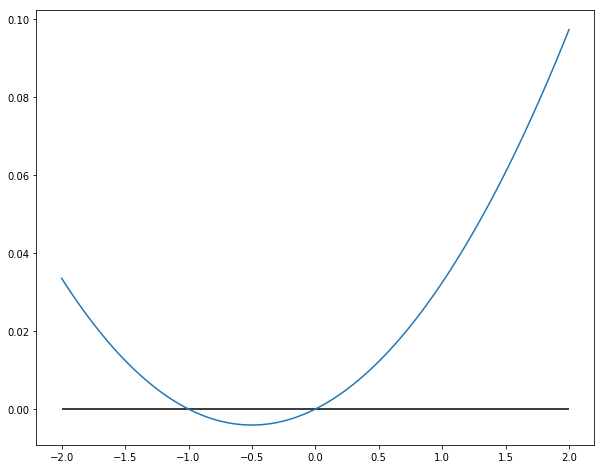

In [111]:
plt.plot(x,f(x))
plt.hlines(0, -2,2)
plt.show()

Её производная

In [77]:
from math import log
def f_h(h):
    return p*((pu/pl)**h*log((pu/pl))-((1-pu)/(1-pl))**h*log((1-pu)/(1-pl))) + ((1-pu)/(1-pl))**h*log((1-pu)/(1-pl))

Решение уравнения

In [113]:
from scipy import optimize
sol = optimize.root_scalar(f, x0=-1.5, fprime=f_h, method='newton')
sol.root, sol.iterations, sol.function_calls

(-0.9999999999999929, 5, 11)

По смыслу подходит h = -1

In [119]:
h = sol.root

In [120]:
import math

L_p = (A**h-1)/(A**h-B**h)
N = (L_p*math.log(B)+(1-L_p)*math.log(A))/(p*math.log(pu/pl)+(1-p)*math.log((1-pu)/(1-pl)))

Матождиание требуемого количества итераций

In [121]:
N

162.68983081831092